In [97]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import pystan

In [98]:
def intersectscore(r1, r2):
    s1 = set(r1)
    s2 = set(r2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def kendaltauscore(r1, r2):
    rfact = pd.factorize(list(set(r1).union(set(r2))))
    rfact = zip(rfact[1], rfact[0])
    rfact = dict(rfact)
    depth = len(rfact) + 50
    r1v = len(rfact) * np.ones(depth)
    r2v = len(rfact) * np.ones(depth)
    for i in range(10):
        r1v[rfact[r1[i]]] = i
        r2v[rfact[r2[i]]] = i
    r1v = r1v.astype(int)
    r2v = r2v.astype(int)
    return kendalltau(r1v, r2v).correlation

In [99]:
df = pd.read_csv("qrels.all.txt", sep=" ", error_bad_lines=False,
                names=["topic_item", "na", "doc", "gold"])

In [100]:
roundedscoremagnitude = 0.1
df.gold = df.gold + np.random.normal(0, roundedscoremagnitude, len(df.gold))

In [101]:
def trunc_docs(df, maxdocs):
    result = []
    for item in df["topic_item"].unique():
        idf = df[df["topic_item"] == item]
        udocs = idf["doc"].unique()
        chosendocs = np.random.choice(udocs, maxdocs, replace=False) if len(udocs) > maxdocs else udocs
        result.append(idf[idf["doc"].isin(chosendocs)])
    return pd.concat(result)

In [102]:
tdf = trunc_docs(df, 50)

In [103]:
def factorize(df, colname):
    lookup = pd.factorize(df[colname].unique())
    result = pd.Categorical(df[colname]).codes
    return result, lookup

topic_factors, topic_factor_lookup = factorize(tdf, "topic_item")
tdf["topic_item"] = topic_factors

In [104]:
print(df.groupby("topic_item").doc.nunique()[:5])
print(tdf.groupby("topic_item").doc.nunique()[:5])

topic_item
251    274
252    286
253    214
254    245
255    404
Name: doc, dtype: int64
topic_item
0    50
1    50
2    50
3    50
4    50
Name: doc, dtype: int64


In [105]:
def create_item_param_dicts(df, ambiguity_beta_a, ambiguity_beta_b, difficulty_loc, difficulty_scale):
    ambiguity_dict = {}
    difficulty_dict = {}
    for i in df["topic_item"].unique():
        ambiguity_dict[i] = np.random.beta(ambiguity_beta_a, ambiguity_beta_b)
        difficulty_dict[i] = np.random.lognormal(difficulty_loc, difficulty_scale)
    return ambiguity_dict, difficulty_dict

ambiguity_dict, difficulty_dict = create_item_param_dicts(tdf, .4, .8, -2, .3)
print(ambiguity_dict)
print(difficulty_dict)

{0: 0.2845585240605907, 1: 0.06185586627736752, 2: 0.0015952111831830835, 3: 0.0043663122914465065, 4: 0.01241647753139648, 5: 0.006427171509198969, 6: 0.0006063652311427119, 7: 0.16923730642009127, 8: 0.9865240471572297, 9: 0.01081912648959322, 10: 0.8584545476044748, 11: 0.012899478281009801, 12: 0.33371206902831185, 13: 0.4655256772316571, 14: 0.9310570224409777, 15: 0.12771157525222596, 16: 0.07022341709405497, 17: 0.00432284583536309, 18: 0.649625396823024, 19: 0.47226002710422216, 20: 0.29397862335697905, 21: 0.005725860606382812, 22: 0.8186844177563263, 23: 0.3184800442481293, 24: 0.2561148419612065, 25: 0.03801794188471763, 26: 0.5848207692862483, 27: 0.9578856636038192, 28: 0.8137180823059312, 29: 0.007663922192337463, 30: 0.4936994926841879, 31: 0.0236973258033646, 32: 0.04718225917743851, 33: 0.06542509919555922, 34: 0.23894392093983371, 35: 0.33669787797106077, 36: 0.022668858088174378, 37: 0.1877358818729389, 38: 0.09754943929848517, 39: 0.7549239693824477, 40: 0.335310200

In [106]:
np.random.normal(0, [1,.1,.1,10], 4)

array([1.33115670e+00, 1.03883209e-01, 1.07731712e-02, 1.38882829e+01])

In [107]:
def create_user_data(uid, df, pct_topics, u_err, ambiguity_dict=None, difficulty_dict=None):
    items = df.topic_item.unique()
    n_items_rated = int(np.round(pct_topics * len(items)))
    items_rated = sorted(np.random.choice(items, n_items_rated, replace=False))
    rdfs = []
    for item in items_rated:
        i_ambiguity = 0 if ambiguity_dict is None else ambiguity_dict.get(item)
        idf = df[df.topic_item == item]
        idflen = len(idf)
        ratings = idf.gold + (1 - i_ambiguity) * np.random.normal(0, u_err, idflen)
        if difficulty_dict is not None:
            i_difficulty = difficulty_dict.get(item)
            ratings += i_ambiguity * np.random.normal(0, i_difficulty, idflen)
        dfdict = {
            "uid": [uid] * idflen,
            "topic_item": [item] * idflen,
            "doc": idf.doc,
            "ratings": ratings,
            "gold": idf.gold
        }
        rdfs.append(pd.DataFrame(dfdict))
    return pd.concat(rdfs)

In [108]:
def creat_sim_df(df, n_users, err_rates, pct_topics=.5,):
    udatas = []
    for i in range(n_users):
        udatas.append(create_user_data(i, df, pct_topics, err_rates[i]))
    return pd.concat(udatas)

def creat_sim_df2(df, n_users1, n_users2, err_rate1=0.1, err_rate2=0.5, pct_topics=.5):
    udatas = []
    for i in range(n_users1):
        udatas.append(create_user_data(i, df, pct_topics, err_rate1))
    for i in range(n_users2):
        udatas.append(create_user_data(n_users1 + i, df, pct_topics, err_rate2))
    return pd.concat(udatas)

$$ P(Liu | v_i, e_u) = v_i + N(0, e_u^2) $$
$$ P(Diuw | v_i, e_u, e_w) = v_i + N(0, e_u^2) - (v_i + N(0, e_w^2)) $$
$$    = N(0, e_u^2 + e_w^2) $$


$$ P(Liu | v_i, e_u) = v_i + (1 - a_i) N(0, e_u^2) + a_i N(0, d_i^2) $$
$$ P(Diuw | v_i, e_u, e_w) = v_i + N(0, ((1 - a_i) e_u)^2) + N(0, (a_i d_i)^2) - (v_i + N(0, ((1 - a_i) e_w)^2) + N(0, (a_i d_i)^2)) $$
$$    = N(0, ((1 - a_i) e_u)^2 + ((1 - a_i) e_w)^2 + 2(a_i d_i)^2) $$
$$    = N(0, (1 - a_i)^2 e_u^2 + (1 - a_i)^2 e_w^2 + 2(a_i d_i)^2) $$
$$    = N(0, (1 - a_i)^2 (e_u^2 + e_w^2) + 2 a_i^2 d_i^2) $$


In [109]:
n_users = 20
err_rates = np.random.lognormal(-1, .5, n_users) / 2

In [110]:
err_rates

array([0.28245248, 0.14298942, 0.25435387, 0.13252564, 0.2369874 ,
       0.29262674, 0.13877477, 0.14228868, 0.20166649, 0.10492553,
       0.10351185, 0.13809852, 0.26822823, 0.36809454, 0.14330742,
       0.29823512, 0.10310931, 0.35564587, 0.09384925, 0.34878349])

In [111]:
sim_df = creat_sim_df(tdf, n_users=n_users, err_rates=err_rates)

In [112]:
sim_df.head()

,uid,topic_item,doc,ratings,gold
276,0,1,clueweb12-0000wt-01-18481,0.901117,1.015093
278,0,1,clueweb12-0000wt-01-20053,0.085831,-0.185110
280,0,1,clueweb12-0007wb-81-24963,-0.429822,-0.074908
288,0,1,clueweb12-0111wb-51-15488,0.474305,0.164113
291,0,1,clueweb12-0203wb-68-21691,0.169338,-0.010186


In [154]:
def calc_list_similarities(df, similarity_fn, topK=10):
    items = []
    u1s = []
    u2s = []
    similarities = []
    for item in df["topic_item"].unique():
        idf = df[df["topic_item"] == item]
        users = idf["uid"].unique()
        for u1, u2 in combinations(users, 2):
            r1 = list(idf[idf["uid"]==u1].ratings.sort_values(ascending=False)[:topK].index)
            r2 = list(idf[idf["uid"]==u2].ratings.sort_values(ascending=False)[:topK].index)
            similarity = similarity_fn(r1, r2)
            items.append(item)
            u1s.append(u1)
            u2s.append(u2)
            similarities.append(similarity)
    return {
        "items":np.array(items) + 1,
        "u1s":np.array(u1s) + 1,
        "u2s":np.array(u2s) + 1,
        "similarities":similarities
    }

stan_data = calc_list_similarities(sim_df, intersectscore)

In [155]:
stan_data["NDATA"] = len(stan_data["similarities"])
stan_data["NITEMS"] = len(sim_df["topic_item"].unique())
stan_data["NUSERS"] = len(sim_df["uid"].unique())

In [156]:
sddf = pd.DataFrame(stan_data)
sddf[sddf["similarities"] < 0.4].head()

,items,u1s,u2s,similarities,NDATA,NITEMS,NUSERS
0,2,1,2,0.333333,2401,50,20
1,2,1,3,0.333333,2401,50,20
3,2,1,8,0.333333,2401,50,20
4,2,1,9,0.333333,2401,50,20
8,2,1,15,0.333333,2401,50,20


In [157]:
s1 = np.concatenate((sddf.groupby("u1s").sum()["similarities"].values, [0]))
s2 = np.concatenate(([0], sddf.groupby("u2s").sum()["similarities"].values))
n1 = np.concatenate((sddf.groupby("u1s").count()["similarities"].values, [0]))
n2 = np.concatenate(([0], sddf.groupby("u2s").count()["similarities"].values))

In [158]:
avg_similarities = (s1 + s2) / (n1 + n2)

In [121]:
stan_model = pystan.StanModel(file="similarity.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8d3d71322ef7791c887df0f2a58cf74 NOW.


In [162]:
stan_data["c_prior_mu"] = 2
stan_data["c_prior_scale"] = .1
opt = stan_model.optimizing(data=stan_data,verbose=True,iter=2000)

In [163]:
print(opt["c1"], opt["c2"])

1.9983320166385699 1.9847904200111761


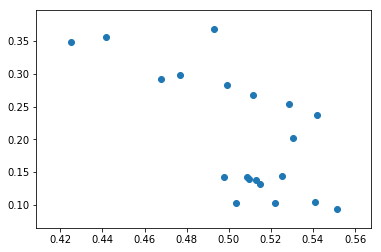

[[ 1.         -0.68639145]
 [-0.68639145  1.        ]]


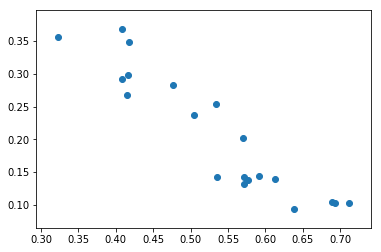

[[ 1.        -0.9275431]
 [-0.9275431  1.       ]]


In [164]:
plt.scatter(avg_similarities, err_rates)
plt.show()
print(np.corrcoef(avg_similarities, err_rates))
plt.scatter(opt["err"], err_rates)
plt.show()
print(np.corrcoef(opt["err"], err_rates))

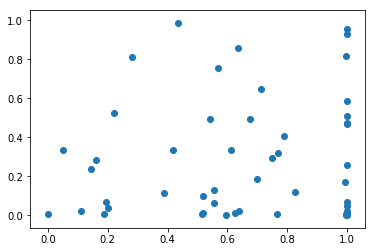

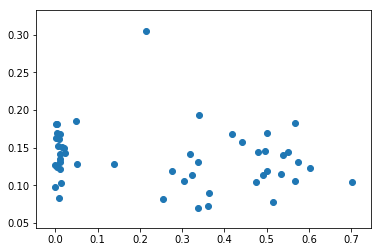

In [165]:
plt.scatter(opt["amb"], list(ambiguity_dict.values()))
plt.show()
plt.scatter(opt["diff"], list(difficulty_dict.values()))
plt.show()

In [133]:
list(ambiguity_dict.values())

[0.2845585240605907,
 0.06185586627736752,
 0.0015952111831830835,
 0.0043663122914465065,
 0.01241647753139648,
 0.006427171509198969,
 0.0006063652311427119,
 0.16923730642009127,
 0.9865240471572297,
 0.01081912648959322,
 0.8584545476044748,
 0.012899478281009801,
 0.33371206902831185,
 0.4655256772316571,
 0.9310570224409777,
 0.12771157525222596,
 0.07022341709405497,
 0.00432284583536309,
 0.649625396823024,
 0.47226002710422216,
 0.29397862335697905,
 0.005725860606382812,
 0.8186844177563263,
 0.3184800442481293,
 0.2561148419612065,
 0.03801794188471763,
 0.5848207692862483,
 0.9578856636038192,
 0.8137180823059312,
 0.007663922192337463,
 0.4936994926841879,
 0.0236973258033646,
 0.04718225917743851,
 0.06542509919555922,
 0.23894392093983371,
 0.33669787797106077,
 0.022668858088174378,
 0.1877358818729389,
 0.09754943929848517,
 0.7549239693824477,
 0.3353102004104435,
 0.008916912686922025,
 0.5068240765124415,
 0.4958887875677357,
 0.5259971883610775,
 4.8608837464087504

In [295]:
# test

udata1 = create_user_data(1, df, 1, 0.1)
udata2 = create_user_data(2, df, 1, 0.1)
r1 = list(udata1[udata1.topic_item==251].ratings.sort_values(ascending=False)[:10].index)
r2 = list(udata2[udata2.topic_item==251].ratings.sort_values(ascending=False)[:10].index)
print(kendaltauscore(r1, r2))
print(intersectscore(r1, r2))

0.32066115702479336
0.25


[0.2845585240605907,
 0.06185586627736752,
 0.0015952111831830835,
 0.0043663122914465065,
 0.01241647753139648,
 0.006427171509198969,
 0.0006063652311427119,
 0.16923730642009127,
 0.9865240471572297,
 0.01081912648959322,
 0.8584545476044748,
 0.012899478281009801,
 0.33371206902831185,
 0.4655256772316571,
 0.9310570224409777,
 0.12771157525222596,
 0.07022341709405497,
 0.00432284583536309,
 0.649625396823024,
 0.47226002710422216,
 0.29397862335697905,
 0.005725860606382812,
 0.8186844177563263,
 0.3184800442481293,
 0.2561148419612065,
 0.03801794188471763,
 0.5848207692862483,
 0.9578856636038192,
 0.8137180823059312,
 0.007663922192337463,
 0.4936994926841879,
 0.0236973258033646,
 0.04718225917743851,
 0.06542509919555922,
 0.23894392093983371,
 0.33669787797106077,
 0.022668858088174378,
 0.1877358818729389,
 0.09754943929848517,
 0.7549239693824477,
 0.3353102004104435,
 0.008916912686922025,
 0.5068240765124415,
 0.4958887875677357,
 0.5259971883610775,
 4.8608837464087504